```{thebe-init}
---
thebe: true
---
```

# Análise de PERT/CPM - Incertezas nas durações das atividades

Conforme visto, o método **PERT (Program Evaluation and Review Technique)** é uma técnica de gerenciamento de projetos que considera a incerteza nas durações das atividades. A técnica utiliza três estimativas: **otimista (o)**, **mais provável (m)** e **pessimista (p)**. A partir dessas estimativas, calcula-se a **média** \($\mu$\) e a **variância** \($\sigma^2$\) de cada atividade, permitindo uma melhor previsão dos prazos do projeto, mesmo diante de incertezas. Essa abordagem, combinada com o **CPM (Critical Path Method)**, auxilia na identificação do caminho crítico, ou seja, a sequência de atividades que determina a duração mínima do projeto.

As fórmulas utilizadas no cálculo são:
Aqui estão as fórmulas em LaTeX adequadas para Markdown:

- **Duração esperada \($\mu$\):**  
  \[
  $\mu = \frac{o + 4m + p}{6}$
  \]

- **Variância \($\sigma^2$\):**  
  \[
  $\sigma^2 = \left( \frac{p - o}{6} \right)^2$
  \]

In [ ]:
import pandas as pd
from fractions import Fraction

# Dados de entrada (sem as colunas Média e Variância)
data = {
    'Atividade': ['Início', 'A', 'B', 'C', 'D', 
                  'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'Fim'],
    'Descrição': ['Início', 'Escavação', 'Fundação', 'Paredes', 'Telhado', 
                  'Encanamento<br>Exterior', 'Encanamento<br>Interior', 'Muros', 
                  'Pintura<br>Exterior', 'Instalação<br>Elétrica', 'Divisórias', 'Piso', 
                  'Pintura<br>Interior', 'Acabamento<br>Exterior', 'Acabamento<br>Interior', 'Fim'],
    #'Atividades Precedentes': [None, 'Início', 'A', 'B', 'C', 'C', 'E', 'D', 'E,G', 'C', 'F,I', 'J', 'J', 'H', 'K,L', 'M,N'],
    'Duração Estimada': [0, 2, 4, 10, 6, 4, 5, 7, 9, 7, 8, 4, 5, 2, 6, 0],
    'o': [None, 1, 2, 6, 4, 1, 4, 5, 5, 3, 3, 4, 1, 1, 5, None],
    'm': [None, 2, 3.5, 9, 5.5, 4.5, 4, 6.5, 8, 7.5, 9, 4, 5.5, 2, 5.5, None],
    'p': [None, 3, 8, 18, 10, 5, 10, 11, 17, 9, 9, 4, 7, 3, 9, None]
}

# Função para calcular a média e a variância
def calculate_mean_variance(o, m, p):
    if pd.isna(o) or pd.isna(m) or pd.isna(p):
        return None, None
    # Média: (o + 4m + p) / 6
    mean = (o + 4 * m + p) / 6
    # Variância: ((p - o) / 6) ** 2
    variance = ((p - o) / 6) ** 2
    # Converter variância para fração mínima
    variance_fraction = str(Fraction(variance).limit_denominator())
    return mean, variance_fraction

# Criar o DataFrame com o cálculo da média e variância no momento da criação
df = pd.DataFrame(data)

# Calcular a média e a variância para cada linha
df['Média'], df['Variância'] = zip(*df.apply(lambda row: calculate_mean_variance(row['o'], row['m'], row['p']), axis=1))

# Exibindo o DataFrame com formatação HTML (para mostrar as quebras de linha corretamente)
from IPython.display import display, HTML

# Exibindo o DataFrame com HTML
display(HTML(df.to_html(escape=False)))


Além dos caminhos que consideram a média do projeto, considerando as estimativas pessimistas e otimistas, é possível calcular o pior e o melhor cenário.

In [ ]:
import pandas as pd
import networkx as nx
from IPython.core.display import display, HTML

# Criar o DataFrame com as informações das atividades
data = pd.DataFrame({
    'Atividade': ['Início', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'Fim'],
    'Descrição': ['Início','Escavação', 'Fundação', 'Paredes', 'Telhado', 'Encanamento Exterior', 
                  'Encanamento Interior', 'Muros', 'Pintura Exterior', 'Instalação Elétrica', 'Divisórias', 
                  'Piso', 'Pintura Interior', 'Acabamento Exterior', 'Acabamento Interior', 'Fim'],
    'Atividades Precedentes': [None, 'Início', 'A', 'B', 'C', 'C', 'E', 'D', 'E,G', 'C', 'F,I', 'J', 'J', 'H', 'K,L', 'M,N'],
    'Duração Estimada': [0, 2, 4, 10, 6, 4, 5, 7, 9, 7, 8, 4, 5, 2, 6, 0],
    'Duração Otimista': [0, 1, 2, 6, 4, 1, 4, 5, 5, 3, 3, 4, 1, 1, 5, 0],
    'Duração Pessimista': [0, 3, 8, 18, 10, 5, 10, 11, 17, 9, 9, 4, 7, 3, 9, 0]
})

# Função para calcular os caminhos e destacar o caminho crítico
def calculate_paths_and_critical(data, duration_column, highlight_color):
    G = nx.DiGraph()

    # Adicionar nós e arestas ao grafo com base na coluna de duração especificada
    for i, row in data.iterrows():
        G.add_node(row['Atividade'], duração=row[duration_column])
        if row['Atividades Precedentes']:
            precedentes = row['Atividades Precedentes'].split(',')
            for p in precedentes:
                G.add_edge(p.strip(), row['Atividade'])

    # Função para encontrar todos os caminhos do início ao fim
    def find_paths(graph, start, end, path=[]):
        path = path + [start]
        if start == end:
            return [path]
        if start not in graph:
            return []
        paths = []
        for node in graph[start]:
            if node not in path:
                new_paths = find_paths(graph, node, end, path)
                for p in new_paths:
                    paths.append(p)
        return paths

    # Encontrar todos os caminhos do "Início" para "Fim"
    all_paths = find_paths(G, 'Início', 'Fim')

    # Calcular a duração de cada caminho
    path_durations = []
    for path in all_paths:
        duration = sum(G.nodes[node]['duração'] for node in path)
        path_durations.append((path, duration))

    # Criar uma tabela com os caminhos e suas durações
    paths_df = pd.DataFrame(path_durations, columns=['Caminho', 'Duração Total'])
    paths_df['Caminho'] = paths_df['Caminho'].apply(lambda x: ' -> '.join(x))  # Formatar o caminho como uma string

    # Encontrar o caminho crítico (o de maior duração)
    critical_path, critical_duration = max(path_durations, key=lambda x: x[1])

    # Função para destacar o caminho crítico na cor especificada
    def highlight_critical(path):
        return ' -> '.join(
            [f"<span style='color:{highlight_color}'>{node}</span>" if node in critical_path else node for node in path]
        )

    # Destacar o caminho crítico e a duração total na tabela
    paths_df['Caminho'] = paths_df['Caminho'].apply(lambda x: highlight_critical(x.split(' -> ')))
    paths_df['Duração Total'] = paths_df['Duração Total'].apply(
        lambda x: f"<span style='color:{highlight_color}'><b>{x}</b></span>" if x == critical_duration else x
    )

    # Retornar o DataFrame formatado
    return paths_df

# Tabela para a duração otimista (destacado em azul)
optimistic_paths_df = calculate_paths_and_critical(data, 'Duração Otimista', 'blue')

# Tabela para a duração estimada (destacado em verde)
estimated_paths_df = calculate_paths_and_critical(data, 'Duração Estimada', 'green')

# Tabela para a duração pessimista (destacado em vermelho)
pessimistic_paths_df = calculate_paths_and_critical(data, 'Duração Pessimista', 'red')

# Exibir as tabelas
display(HTML("<h3>Duração Otimista</h3>"))
display(HTML(optimistic_paths_df.to_html(escape=False)))

display(HTML("<h3>Duração Estimada</h3>"))
display(HTML(estimated_paths_df.to_html(escape=False)))

display(HTML("<h3>Duração Pessimista</h3>"))
display(HTML(pessimistic_paths_df.to_html(escape=False)))


### Distribuição Normal e Cálculo da Probabilidade

A **distribuição normal** pode ser utilizada para modelar o tempo total de um projeto no contexto do PERT/CPM, considerando as incertezas nas durações das atividades. Ela é caracterizada pela **média** ($\mu$), que representa o tempo esperado do projeto, e o **desvio padrão** ($\sigma$), que reflete a variabilidade no tempo de conclusão do projeto. O desvio padrão total do caminho crítico é calculado somando as variâncias das atividades nesse caminho.

A **probabilidade** de concluir o projeto em um tempo $T$ é dada pela função de distribuição acumulada normal (CDF):


$
P(T) = P(X \leq T) = \Phi\left( \frac{T - \mu_p}{\sigma_p} \right)
$


Onde:
- $\Phi$ é a função de distribuição acumulada da normal.
- $\mu_p$ é a média do tempo total do caminho crítico.
- $\sigma_p$ é o desvio padrão do caminho crítico, calculado pela raiz quadrada da soma das variâncias das atividades no caminho crítico.
- $T$ é o tempo fornecido para calcular a probabilidade.

O **desvio padrão** do caminho crítico é calculado por:

$
\sigma_p = \sqrt{\sum_{i=1}^{n} \sigma_i^2}
$

Onde $\sigma_i^2$ é a variância de cada atividade no caminho crítico, e $n$ é o número de atividades nesse caminho.

A probabilidade de o projeto ser completado em 47.0 unidades de tempo é: 0.8413


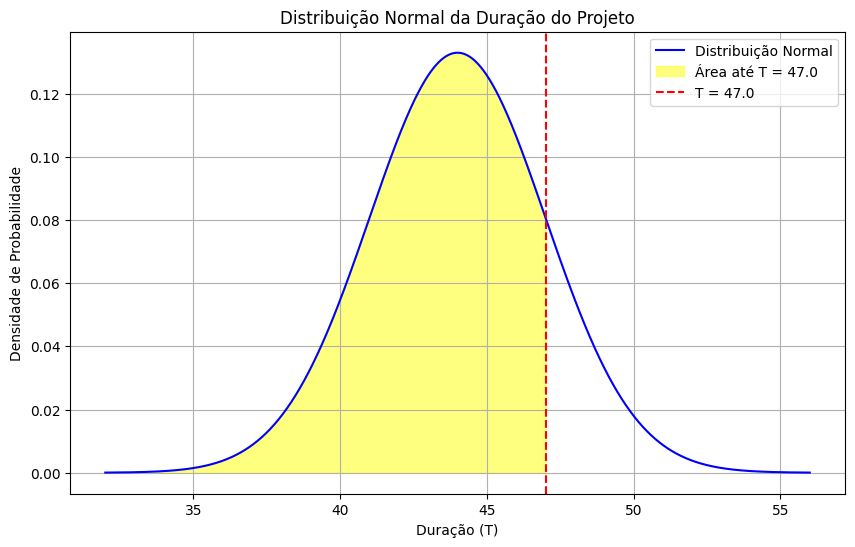

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from fractions import Fraction

# Função para calcular a probabilidade
def calcular_probabilidade(mu_p, variancia_atividades, T):
    # Passo 1: Calcular o desvio padrão total (σ_p)
    sigma_p = math.sqrt(sum(variancia_atividades))
    
    # Passo 2: Calcular o número de desvios padrão (k_a)
    k_a = (T - mu_p) / sigma_p
    
    # Passo 3: Calcular a probabilidade usando a distribuição normal
    probabilidade = norm.cdf(k_a)  # Função de distribuição acumulada da normal
    return probabilidade, sigma_p, k_a

# Função para converter frações em números decimais
def fração_para_decimal(fração_str):
    try:
        return float(Fraction(fração_str.strip()))
    except ValueError:
        print(f"Erro ao converter a fração: {fração_str}. Certifique-se de usar o formato correto, como '1/9'.")
        return 0.0

# Solicitar ao usuário a duração total do Caminho Crítico e as variâncias das atividades
mu_p = float(input("Informe a duração total do Caminho Crítico (μ_p) em unidades de tempo: ")) # Exemplo anterior: Caminho crítico Médio: Início -> A -> B -> C -> E -> F -> J -> L -> N -> Fim:	44
variancia_atividades = list(map(fração_para_decimal, input("Informe as variâncias das atividades separadas por vírgula (por exemplo, '1/9'): ").split(','))) # Exemplo anterior atividades: 1/9, 1, 4, 4/9, 1, 1, 1, 4/9 

# Solicitar o tempo T para calcular a probabilidade
T = float(input("Informe a duração do projeto (T) para calcular a probabilidade: ")) # Exemplo anterior o desvio padrão é 3

# Calcular a probabilidade
probabilidade, sigma_p, k_a = calcular_probabilidade(mu_p, variancia_atividades, T)

# Exibir o resultado
print(f"A probabilidade de o projeto ser completado em {T} unidades de tempo é: {probabilidade:.4f}")

# Gerar o gráfico da distribuição normal
x = np.linspace(mu_p - 4*sigma_p, mu_p + 4*sigma_p, 1000)
y = norm.pdf(x, mu_p, sigma_p)

plt.figure(figsize=(10, 6))

# Plotar a distribuição normal
plt.plot(x, y, label="Distribuição Normal", color='blue')

# Destacar a área da probabilidade em amarelo
x_fill = np.linspace(mu_p - 4*sigma_p, T, 1000)
y_fill = norm.pdf(x_fill, mu_p, sigma_p)
plt.fill_between(x_fill, y_fill, color='yellow', alpha=0.5, label=f'Área até T = {T}')

# Adicionar marcação de T
plt.axvline(x=T, color='red', linestyle='--', label=f'T = {T}')

# Adicionar títulos e rótulos
plt.title('Distribuição Normal da Duração do Projeto')
plt.xlabel('Duração (T)')
plt.ylabel('Densidade de Probabilidade')
plt.legend()

# Exibir o gráfico
plt.grid(True)
plt.show()
